
# cGAN Code for SINR Estimation

- **Author:** Matheus Ferreira Silva 
- **Email:** matheus.ferreira@get.inatel.br
- **Date:** September 2024

## Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Disable TensorFlow warnings

import keras
import datetime
import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.preprocessing import MinMaxScaler
from keras import layers, Input, Model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


## Utils

In [2]:
# Directory to save the checkpoints
checkpoint_dir = "checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Create a logs directory for TensorBoard
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

## GPU

In [3]:
# Specify GPU to use (e.g., GPU 0)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"Available GPU(s): {[gpu.name for gpu in gpus]}")
    print(f"Using GPU: {tf.test.gpu_device_name()}")
else:
    print("No GPU detected. Running on CPU.")

# Display TensorFlow version and CUDA/cuDNN information if available
print(f"TensorFlow version: {tf.__version__}")

if tf.test.is_built_with_cuda():
    build_info = tf.sysconfig.get_build_info()
    print(f"TensorFlow is built with CUDA support")
    print(f"CUDA version: {build_info['cuda_version']}")
    print(f"cuDNN version: {build_info['cudnn_version']}")
else:
    print("Running on CPU (No CUDA support detected).")


Available GPU(s): ['/physical_device:GPU:0']
Using GPU: /device:GPU:0
TensorFlow version: 2.17.0
TensorFlow is built with CUDA support
CUDA version: 12.3
cuDNN version: 8


I0000 00:00:1727262479.041394  899406 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727262479.169133  899406 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727262479.174003  899406 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727262479.180371  899406 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

## Constants and hyperparameters

In [4]:
num_ports = 144  # Total number of ports
latent_dim = 128  # Latent space dimension (random noise)
batch_size = 32  # Batch size for training
channels = 1 # SINR data has 1 channel (real values)
SEED = 42 # Set random seed for reproducibility

# Set the seeds for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Load and Preprocess Data

In [5]:
def load_sinr_data(filepath, key="gamma_k"):
    """
    Loads the SINR data from a .mat file and reshapes it.

    Args:
        filepath (str): Path to the .mat file containing SINR data.
        key (str): Key to access the SINR matrix inside the .mat file.

    Returns:
        sinr_data (np.array): Loaded and reshaped SINR data of shape (num_samples, height, width, channels).
    """
    # Load the .mat file
    mat = scipy.io.loadmat(filepath)

    # Extract the SINR matrix
    sinr_matrix = mat[key]

    return sinr_matrix

In [6]:
# Load the SINR data from the .mat file
sinr_data = load_sinr_data('data/dataset_SINR_kappa_mu_shadowed/SINR.mat')

# The sinr_data is a matrix (num_samples, num_ports)
print(f"Shape of the data: {sinr_data.shape}")

# ----------------------------- Basic Statistics ----------------------------- #
# Calculate the per-sample min and max values
min_sinr_per_sample = np.min(sinr_data, axis=0)  # Min for each sample (shape: 40000,)
max_sinr_per_sample = np.max(sinr_data, axis=0)  # Max for each sample (shape: 40000,)

# Find the overall min and max values across all samples
min_of_all_min = np.min(min_sinr_per_sample)  # Overall min value
max_of_all_max = np.max(max_sinr_per_sample)  # Overall max value
print(f"Minimum of all min SINR values (smallest across all samples): {min_of_all_min}")
print(f"Maximum of all max SINR values (largest across all samples): {max_of_all_max}")

# ----------------------- Normalize Using MinMaxScaler ----------------------- #
# Initialize MinMaxScaler and scale the SINR data
scaler = MinMaxScaler(feature_range=(0, 1))
sinr_data_scaled = scaler.fit_transform(sinr_data)

# Cast sinr_data to float32
sinr_data = sinr_data_scaled.astype(np.float32)

print(f"Shape of the data after normalization: {sinr_data.shape}")

Shape of the data: (40000, 144)
Minimum of all min SINR values (smallest across all samples): 8.07212628062423e-08
Maximum of all max SINR values (largest across all samples): 117.52307999711444
Shape of the data after normalization: (40000, 144)


## cGAN Model training

#### Generator

In [7]:
def build_generator(latent_dim, observed_ports):
    """
    Builds the generator model for the Conditional GAN (cGAN).
    The generator takes random noise and observed SINR values as input and generates fake SINR maps.
    
    Args:
        latent_dim (int): Dimension of the latent space (random noise).
        observed_ports (int): Number of observed ports (features).
        
    Returns:
        model (tf.keras.Model): The compiled generator model.
    """
    
    # ------------------------------- Input layer ------------------------------- #
    """
    The input noise for the generator z is sampled from the Gaussian distribution with
    zero mean and unit variance with the dimension of 128. Thus, the input Y of the generator 
    is Y = z + L
    
    The latent_dim is the dimension of z (random noise).
    L is the labels (observed SINR values).
    """
    
    inputs = Input(shape=(latent_dim + observed_ports,))
    # Input layer receives a vector of random noise concatenated with observed SINR values.
    # Input shape: (batch_size, latent_dim + observed_ports)

    # First Dense layer for feature generation
    x = layers.Dense(27)(inputs)
    x = layers.LeakyReLU(0.2)(x)  # Apply LeakyReLU activation to introduce non-linearity
    x = layers.BatchNormalization()(x) # Stabilize the network's learning process.
    x = layers.Reshape((3, 3, -1))(x) # Reshape the output into a feature map

    # Convolutional Transpose Layers for upsampling
    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)
    
    # Final convolution to match the output shape
    x = layers.Conv2D(channels, (3, 3), padding="same", activation="sigmoid")(x)
    
    # Output layer
    x = layers.Flatten()(x)
    outputs = layers.Dense(num_ports, activation="sigmoid")(x)

    return Model(inputs=inputs, outputs=outputs)

#### Discriminator

In [8]:
def build_discriminator():
    """
    Builds the discriminator model for the Conditional GAN (cGAN).
    The discriminator distinguishes between real and generated SINR maps.

    Returns:
        model (tf.keras.Model): The compiled discriminator model.
    """

    # Input layer receives a flattened vector of SINR data.
    inputs = Input(shape=(num_ports,))
    
    # First layer
    x = layers.Dense(64)(inputs)
    x = layers.LeakyReLU(0.2)(x)

    # Second layer
    x = layers.Dense(128)(x)
    x = layers.LeakyReLU(0.2)(x)

    # Output layer to distinguish between real and fake data.
    outputs = layers.Dense(1)(x)
    # Dense layer outputs a single value representing real or fake prediction.
    # Output shape: (batch_size, 1)

    return Model(inputs=inputs, outputs=outputs)

#### cGAN Model

In [9]:
class ConditionalGAN(keras.Model):
    """
    Defines the Conditional GAN (cGAN) model that combines the generator and discriminator.

    The model trains the generator to produce SINR maps that fool the discriminator,
    while training the discriminator to correctly distinguish between real and generated SINR maps.
    """

    def __init__(self, generator, discriminator, latent_dim, mse_punishment=100):
        """
        Initializes the Conditional GAN model with generator and discriminator.

        Args:
            generator (tf.keras.Model): The generator model.
            discriminator (tf.keras.Model): The discriminator model.
            latent_dim (int): The dimension of the latent space.
            mse_punishment (float): Weighting factor for the generator loss.
        """
        super(ConditionalGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.mse_tracker = keras.metrics.Mean(name="mse_loss")
        self.mse_punishment = mse_punishment

    @property
    def metrics(self):
        """Returns the tracked metrics for the generator, discriminator, and MSE."""
        return [self.gen_loss_tracker, self.disc_loss_tracker, self.mse_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        """
        Compiles the Conditional GAN model with optimizers and loss function.

        Args:
            d_optimizer (tf.keras.optimizers.Optimizer): Optimizer for the discriminator.
            g_optimizer (tf.keras.optimizers.Optimizer): Optimizer for the generator.
            loss_fn (callable): Loss function to optimize.
        """
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

        # The loss here is a Binary Cross-Entropy loss
        self.loss_fn = loss_fn
        self.mse_fn = keras.losses.MeanSquaredError()

    @tf.function
    def train_step(self, data):
        """
        Defines a single training step for the Conditional GAN.

        This step trains both the generator and discriminator:
        1. The discriminator is trained to differentiate real vs fake images.
        2. The generator is trained to fool the discriminator and match real SINR values.

        Args:
            data (tuple): A tuple containing real SINR data and observed SINR data.

        Returns:
            dict: A dictionary of the generator, discriminator, and MSE losses.
        """
        # Unpack the data: real SINR data and observed SINR ports (context/labels)
        real_images, observed_ports = data

        # Batch size of the current input data
        batch_size = tf.shape(real_images)[0]

        # Generate random noise for the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Flatten observed_sinr to a 2D vector for concatenation with random noise
        observed_ports = tf.reshape(observed_ports, [batch_size, -1])

        # Concatenate the random noise with the observed ports
        generator_input = tf.concat([random_latent_vectors, observed_ports], axis=1)

        # ------------------- Discriminator Training ------------------- #
        # Generate fake SINR maps
        generated_images = self.generator(generator_input)

        # Combine real and fake images for the discriminator
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Create labels for real (1) and fake (0) images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Train the discriminator
        with tf.GradientTape() as tape:
            # Discriminator predictions on real and fake data
            predictions = self.discriminator(combined_images)
            # Calculate discriminator loss using binary cross-entropy
            d_loss = self.loss_fn(labels, predictions)

        # Calculate the gradients of the discriminator loss with respect to the discriminator's weights
        # This computes how much each weight contributes to the loss, which is needed for backpropagation.
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)

        # Apply the computed gradients to the discriminator's weights, updating them to minimize the loss
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # -------------------- Generator Training -------------------- #
        # Generate new random latent vectors
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Concatenate random noise with observed ports for the generator
        generator_input = tf.concat([random_latent_vectors, observed_ports], axis=1)

        # Labels for the generator training (all ones, as we want to fool the discriminator)
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as tape:
            # Generate fake images and pass them through the discriminator
            generated_images = self.generator(generator_input)
            predictions = self.discriminator(generated_images)

            # Calculate generator loss (cross-entropy loss and MSE)
            g_loss = self.loss_fn(misleading_labels, predictions)
            mse_loss = self.mse_fn(real_images, generated_images)

            # Punish the generator with MSE loss
            g_loss = g_loss + mse_loss * self.mse_punishment

        # Compute and apply gradients for generator
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Track losses for visualization
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.mse_tracker.update_state(mse_loss)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "mse": self.mse_tracker.result(),
        }

In [10]:
class LossHistory(Callback):
    """
    Callback class to track and store loss history for generator and discriminator
    during training. Also keeps track of the best epoch based on the lowest MSE.
    """
    def on_train_begin(self, logs=None):
        self.g_loss_history = []
        self.d_loss_history = []
        self.mse_history = []
        self.best_epoch = None  # Track the epoch with the best MSE loss
        self.best_mse = np.Inf  # Initialize with infinity for comparison

    def on_epoch_end(self, epoch, logs=None):
        # Update loss history
        self.g_loss_history.append(logs.get('g_loss'))
        self.d_loss_history.append(logs.get('d_loss'))
        self.mse_history.append(logs.get('mse'))

        # Check if the current MSE is better (lower) than the best one
        current_mse = logs.get('mse')
        if current_mse < self.best_mse:
            self.best_mse = current_mse
            self.best_epoch = epoch + 1  # Save the epoch (1-based index)

## Training

#### Outage Probability Calculations

In [11]:
def compute_ideal_op(sinr_data, threshold):
    """
    Computes the outage probability based on the best SINR value across all ports.

    Args:
        sinr_data (np.array): SINR data for all ports (shape: num_samples, num_ports).
        threshold (float): SINR threshold below which the outage is considered.

    Returns:
        outage_prob (float): The outage probability based on the best SINR value across all ports.
    """
    # Find the best SINR value (max SINR) across all ports for each sample
    best_sinr = np.max(sinr_data, axis=1)  # num_port axis
    outage_prob = np.mean(best_sinr < threshold)  # Check if best SINR is below the threshold
    return outage_prob


def compute_reference_op(observed_sinr, original_sinr, observed_indices, threshold):
    """
    Computes the outage probability based on the best SINR value within the observed ports.

    The function selects the best SINR value from the observed ports, retrieves the corresponding
    SINR value from the original SINR data using the index of the best observed port, and checks
    if it is below the threshold.

    Args:
        observed_sinr (np.array): Observed SINR data for the selected observed ports (shape: num_samples, observed_ports).
        original_sinr (np.array): Original SINR data (shape: num_samples, total_ports).
        observed_indices (np.array): Indices of the observed ports within the total ports.
        threshold (float): SINR threshold below which the outage is considered.

    Returns:
        outage_prob (float): The outage probability based on the best SINR value from the original data for observed ports.
    """
    num_samples = observed_sinr.shape[0]

    # Find the index of the best SINR within the observed ports for each sample
    best_observed_index = np.argmax(
        observed_sinr, axis=1
    )  # Indices of the best observed SINR for each sample

    # Use the observed indices to find the corresponding index in the original SINR data
    best_port_indices = observed_indices[
        best_observed_index
    ]  # Map the observed port index to the original SINR index

    # Retrieve the SINR values from the original SINR data using the mapped indices
    best_port_sinr = np.array([original_sinr[i, best_port_indices[i]] for i in range(num_samples)])

    # Calculate outage probability based on the original SINR values of the best observed port
    outage_prob = np.mean(best_port_sinr < threshold)
    return outage_prob


def compute_model_op(generated_sinr, sinr_data, observed_sinr, observed_indices, threshold):
    """
    Computes the final SINR using the generated (predicted) SINR values, and replaces
    them with the observed SINR values if they are higher than the predicted ones for the
    observed ports.

    Args:
        generated_sinr (np.array): SINR values generated by the model (shape: num_samples, num_ports).
        sinr_data (np.array): Original SINR data (shape: num_samples, num_ports).
        observed_sinr (np.array): Observed SINR values for selected ports (shape: num_samples, observed_ports).
        observed_indices (np.array): Indices of the observed ports within the full set of ports.
        threshold (float): SINR threshold below which the outage is considered.

    Returns:
        outage_prob (float): Outage probability based on the final SINR values.
    """
    num_samples = generated_sinr.shape[0]
    num_ports = generated_sinr.shape[1]

    # Initialize the final SINR with the generated (predicted) SINR
    sinr_final = np.copy(generated_sinr)

    # For each sample, replace the predicted SINR with the observed SINR if it is higher
    for i in range(num_samples):
        for j, observed_port in enumerate(observed_indices):
            # Replace with the observed SINR if it's higher than the predicted one
            sinr_final[i, observed_port] = max(generated_sinr[i, observed_port], observed_sinr[i, j])

    # Calculate the outage probability using the final SINR
    outage_prob = np.mean(np.max(sinr_final, axis=1) < threshold)

    return outage_prob

#### Auxiliary functions

In [12]:
def get_observed_ports(sinr_data, num_samples, num_ports):
    """
    Extracts linearly spaced observed ports from the SINR data and returns the observed indices.

    Args:
        sinr_data (np.array): Full SINR data.
        num_samples (int): Number of samples in the SINR data.
        num_ports (int): Number of observed ports to extract.

    Returns:
        observed_sinr (np.array): Extracted SINR data for the observed ports of shape (num_samples, num_ports, 1, channels).
        observed_indices (np.array): Indices of the observed ports within the total ports.
    """
    observed_indices = np.linspace(0, num_ports - 1, num_ports, dtype=int)
    observed_sinr = sinr_data[:, observed_indices]

    return observed_sinr, observed_indices


def plot_channel_power(predicted, original, n_ports):
    """
    Plots the channel power for predicted and original SINR values over the observed ports.

    Args:
        predicted (np.array): Predicted SINR data for the specific number of observed ports.
        original (np.array): Original SINR data for the specific number of observed ports.
        n_ports (int): Number of observed ports.
    """

    def convert_to_db(data):
        # Add a small epsilon to avoid log(0) issues
        epsilon = 1e-10
        return 10 * np.log10(np.maximum(data, epsilon))

    predicted = convert_to_db(predicted)
    original = convert_to_db(original)

    plt.figure(figsize=(6, 4))

    # Plot predicted and original SINR data
    plt.plot(range(len(predicted)), predicted, label="Predicted", color="blue")
    plt.plot(range(len(original)), original, label="Original", color="orange")

    # Set labels, title, and legend
    plt.xlabel("Port")
    plt.ylabel("Channel power/dB")
    plt.title(f"{n_ports} observed ports")
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()


def plot_outage_probability(ideal_data, reference_data, cgan_data, ports_list):
    """
    Plots the outage probability for ideal, reference, and cGAN-generated data.

    The function creates a plot with the number of observed ports on the x-axis and the
    outage probability (in logarithmic scale) on the y-axis. It plots the outage probabilities
    for the ideal, reference (observed ports), and cGAN-generated data.

    Args:
        ideal_data (list): Outage probabilities for the ideal SINR data.
        reference_data (list): Outage probabilities for the reference (observed ports) SINR data.
        cgan_data (list): Outage probabilities for the cGAN-generated SINR data.
        ports_list (list): List of observed port configurations used for the x-axis.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(ports_list, ideal_data, label="Ideal", color="blue", linestyle="--", marker="o")
    plt.plot(
        ports_list,
        reference_data,
        label="Reference (Observed Ports)",
        color="green",
        linestyle="-",
        marker="x",
    )
    plt.plot(ports_list, cgan_data, label="cGAN", color="orange", linestyle=":", marker="s")
    plt.yscale("log")  # Logarithmic y-axis
    plt.title("Outage Probability vs Number of Observed Ports")
    plt.xlabel("Number of Observed Ports")
    plt.ylabel("Outage Probability")
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()


def plot_losses(g_loss_history, d_loss_history, mse_history, best_epoch):
    """
    Plots the generator, discriminator, and MSE loss histories over epochs, with annotations
    for the epoch where the best weights were saved based on the lowest MSE.

    Args:
        g_loss_history (list): Generator loss history.
        d_loss_history (list): Discriminator loss history.
        mse_history (list): MSE loss history.
        best_epoch (int): The epoch where the best weights were saved.
    """
    epochs = range(1, len(g_loss_history) + 1)

    plt.figure(figsize=(12, 8))

    # Plot Generator Loss
    plt.subplot(3, 1, 1)
    plt.plot(epochs, g_loss_history, label="Generator Loss")
    plt.yscale("log")
    plt.title("Generator Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Annotate Best Generator Loss Value (scientific notation)
    if best_epoch is not None:
        best_g_loss = g_loss_history[best_epoch - 1]
        plt.annotate(
            f"{best_g_loss:.4e}",
            xy=(best_epoch, best_g_loss),
            xytext=(best_epoch, best_g_loss * 1.8),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
            fontsize=10,
        )

    # Plot Discriminator Loss
    plt.subplot(3, 1, 2)
    plt.plot(epochs, d_loss_history, label="Discriminator Loss")
    plt.yscale("log")
    plt.title("Discriminator Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Annotate Best Discriminator Loss Value (scientific notation)
    if best_epoch is not None:
        best_d_loss = d_loss_history[best_epoch - 1]
        plt.annotate(
            f"{best_d_loss:.4e}",
            xy=(best_epoch, best_d_loss),
            xytext=(best_epoch, best_d_loss * 1.8),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
            fontsize=10,
        )

    # Plot MSE Loss
    plt.subplot(3, 1, 3)
    plt.plot(epochs, mse_history, label="MSE Loss")
    plt.yscale("log")
    plt.title("MSE Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()

    # Annotate Best MSE Value (scientific notation)
    if best_epoch is not None:
        best_mse = mse_history[best_epoch - 1]
        plt.annotate(
            f"{best_mse:.4e}",
            xy=(best_epoch, best_mse),
            xytext=(best_epoch, best_mse * 1.8),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
            fontsize=10,
        )

    plt.tight_layout()
    plt.show()


def plot_sinr_histograms(real_data, generated_data, title="SINR Distribution Comparison"):
    """
    Plots histograms of real and generated SINR data.

    Args:
        real_data (np.array): Real SINR data (flattened).
        generated_data (np.array): Generated SINR data (flattened).
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))

    # Plot histograms with a log-scaled x-axis
    plt.hist(real_data, bins=300, alpha=0.6, color="blue", label="Real Distribution", log=True)
    plt.hist(generated_data, bins=300, alpha=0.6, color="orange", label="Generated Distribution", log=True)

    plt.xscale("log")  # Logarithmic x-axis for better visualization of skewed data
    plt.title(title)
    plt.xlabel("Distribution Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


def denormalize_data(normalized_data, scaler):
    """
    Denormalizes the data using the fitted MinMaxScaler.

    The function reshapes the normalized data to a 2D array, applies the inverse transformation
    to bring it back to its original scale, and reshapes it back to its original dimensions.

    Args:
        normalized_data (np.array): The normalized data to be denormalized.
        scaler (MinMaxScaler): The MinMaxScaler object that was used for normalization.

    Returns:
        denormalized_data (np.array): The denormalized data, restored to its original scale.
    """
    shape = normalized_data.shape  # Store original shape
    normalized_data_flat = normalized_data.reshape(-1, 1)  # Flatten the data for inverse transform
    denormalized_data = scaler.inverse_transform(normalized_data_flat).reshape(
        shape
    )  # Inverse transform and reshape
    return denormalized_data

#### Configuration and Initialization

In [13]:
# Making observed ports list in terms of percentage of total number of ports
percentage_step = 0.2
percentage_list = np.arange(percentage_step, 1.0 + percentage_step, percentage_step)  # Percentage list
observed_ports_list = [int(num_ports * 144) for num_ports in percentage_list]
print(f"Observed ports list: {observed_ports_list}")

# Lists to store outage probabilities for ideal, reference, and cGAN models
outage_prob_ideal_list = []
outage_prob_reference_list = []
outage_prob_cgan_list = []

# Define the threshold for outage probability (SINR values below this are considered in outage)
outage_threshold = 0.1  # Threshold in dB

# Number of epochs
epochs = 30

Observed ports list: [28, 57, 86, 115, 144]


#### Loop Over Observed Ports

Training cGAN with 28 observed ports...


I0000 00:00:1727262479.767413  899406 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727262479.769648  899406 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727262479.771523  899406 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727262479.773695  899406 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Restoring model weights from the end of the best epoch: 30.


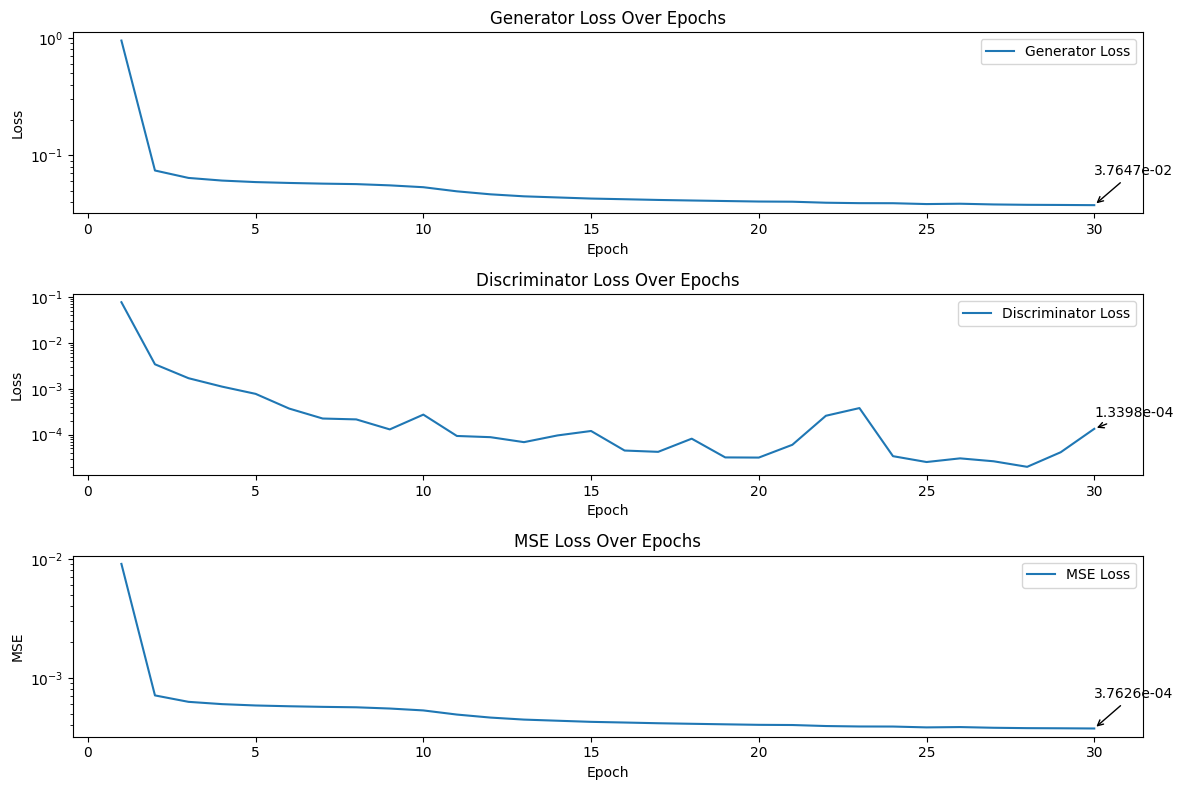

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 630us/step
Training cGAN with 57 observed ports...
Restoring model weights from the end of the best epoch: 29.


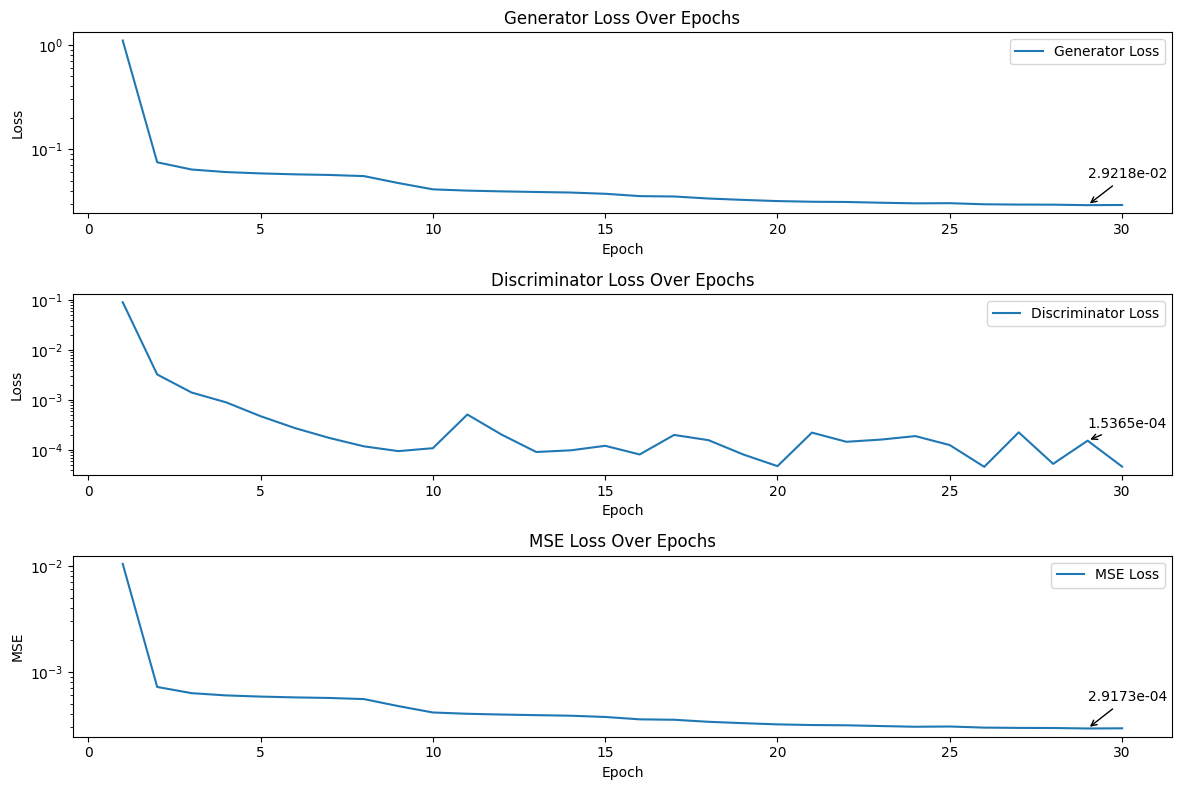

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step
Training cGAN with 86 observed ports...
Restoring model weights from the end of the best epoch: 30.


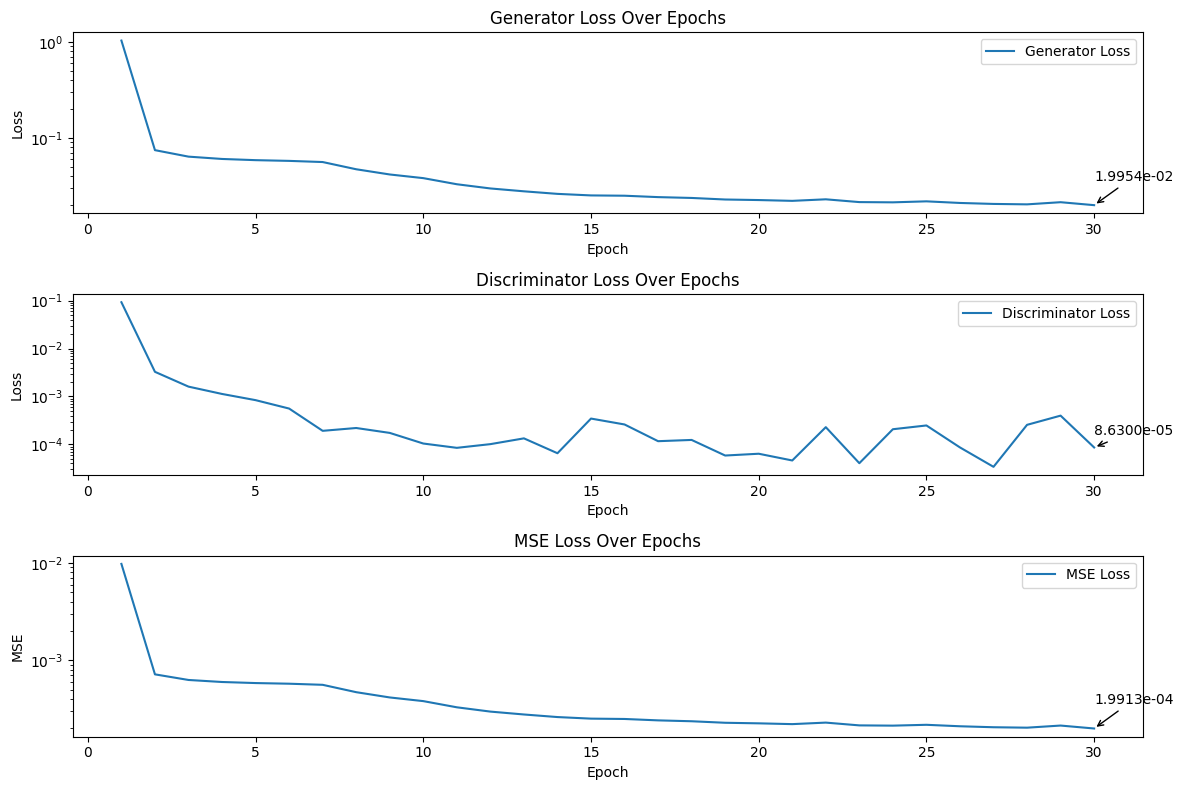

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step
Training cGAN with 115 observed ports...
Restoring model weights from the end of the best epoch: 30.


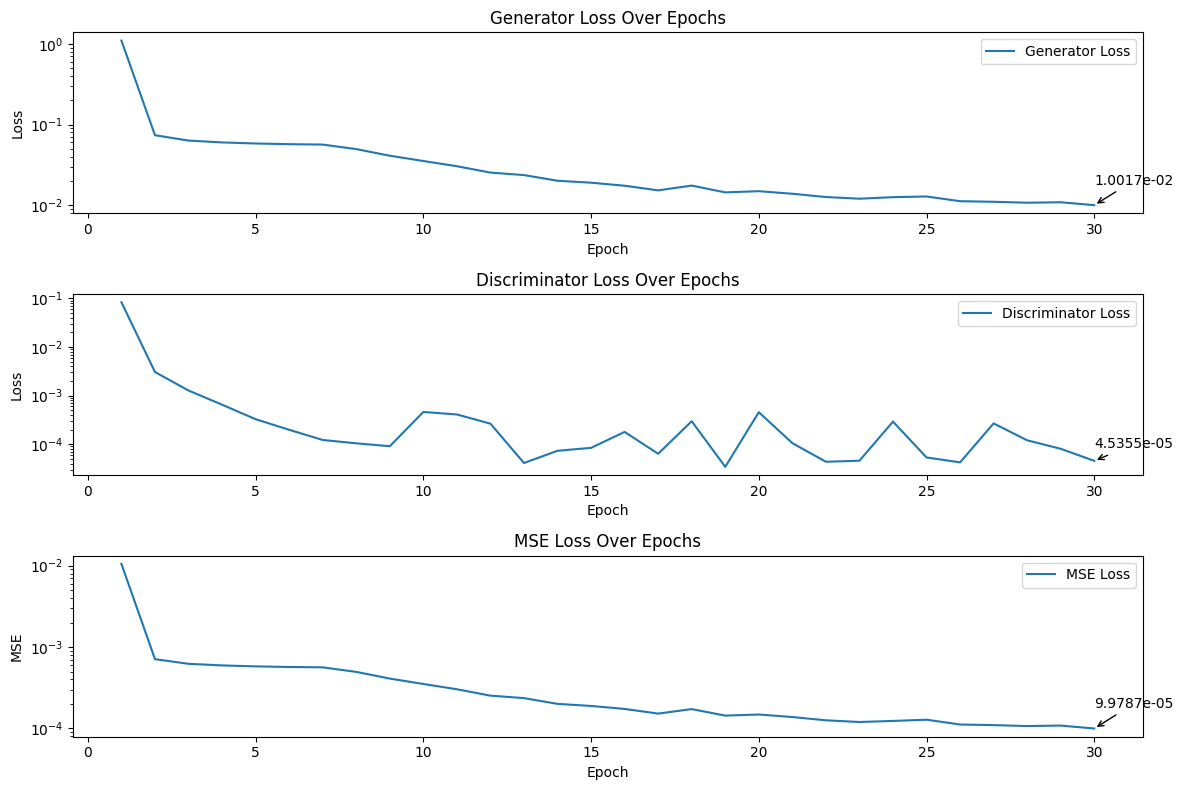

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step
Training cGAN with 144 observed ports...
Restoring model weights from the end of the best epoch: 30.


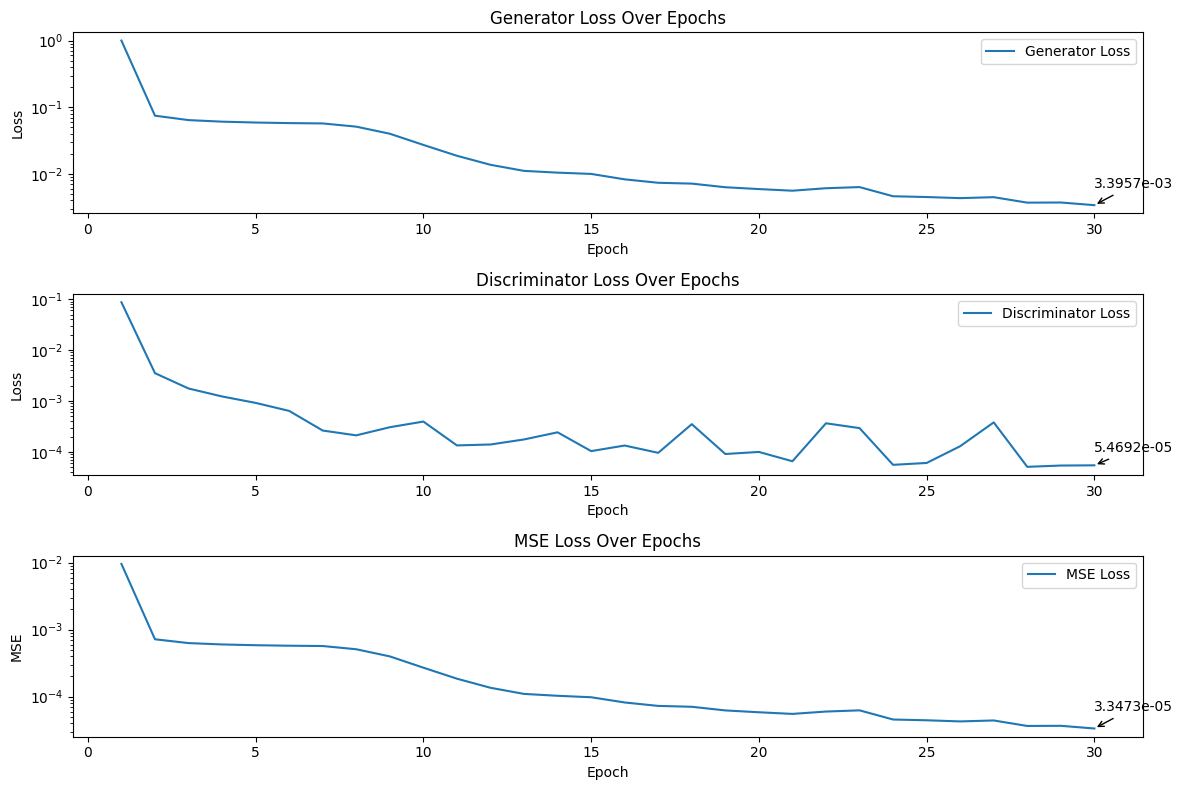

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step


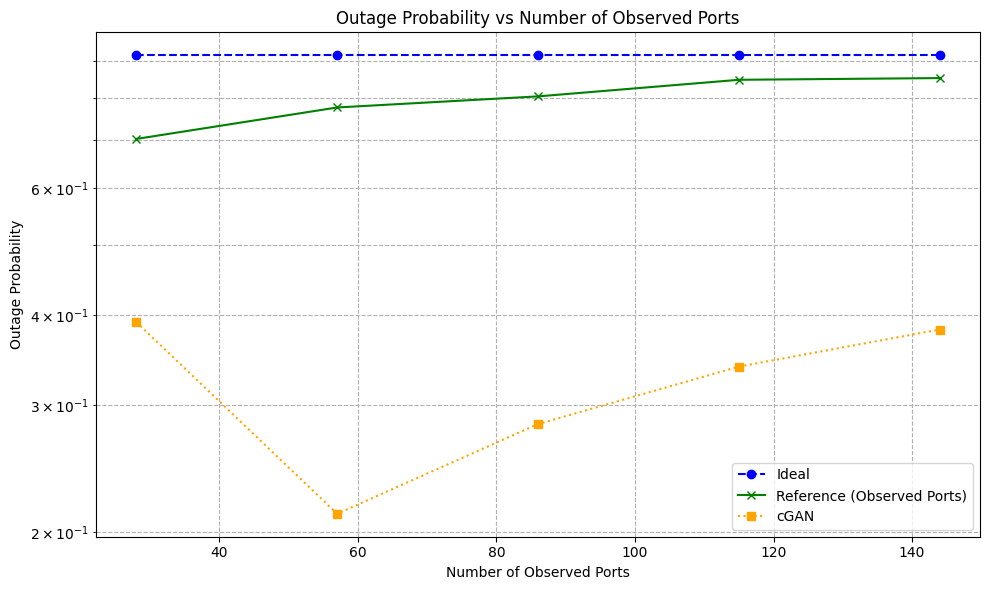

In [14]:
for n in observed_ports_list:
    # Train the cGAN
    print(f"Training cGAN with {n} observed ports...")

    # Update observed ports and dataset
    observed_sinr, observed_indices = get_observed_ports(sinr_data, sinr_data.shape[0], n)
    observed_sinr = observed_sinr.astype(np.float32)
    dataset = tf.data.Dataset.from_tensor_slices((sinr_data, observed_sinr)).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE).cache()  # For large datasets

    # Initialize and compile the cGAN model
    generator = build_generator(latent_dim, n)
    discriminator = build_discriminator()
    cgan = ConditionalGAN(generator, discriminator, latent_dim)
    cgan.compile(
        d_optimizer=keras.optimizers.AdamW(
            learning_rate=0.0002,
            # clipvalue=1.0, Try this on optuna
        ),
        g_optimizer=keras.optimizers.AdamW(
            learning_rate=0.0002,
            # clipvalue=1.0, Try this on optuna
        ),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
    )

    # Instantiate the loss history callback
    loss_history = LossHistory()

    # Define the TensorBoard callback
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Define the checkpoint callback to save the generator and discriminator models
    checkpoint_callback = ModelCheckpoint(
        filepath=os.path.join(
            checkpoint_dir, f"cgan_model_observed_ports_{n}_epoch_{{epoch:02d}}.weights.h5"
        ),
        save_weights_only=True,  # Save only the weights (generator + discriminator)
        monitor="mse",  # Can monitor other losses like 'd_loss' or 'mse'
        mode="min",  # Save when the generator loss is minimized
        save_best_only=False,  # Set to True to save only the best model
        verbose=0,  # Verbose mode for logging the saving process
    )

    # Define the EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor="mse",  # The metric to monitor, from return of train_step
        mode="min",  # Maximize or minimize the metric
        patience=10,  # Number of epochs with no improvement before stopping
        verbose=1,  # Verbosity level (0 = silent, 1 = report stopping)
        restore_best_weights=True,  # Restore the best weights at the end of training
    )

    # Train the cGAN model
    cgan.fit(
        dataset,
        epochs=epochs,
        callbacks=[loss_history, early_stopping, checkpoint_callback, tensorboard_callback],
        verbose=0,
    )
    
    # Run TensorBoard in the terminal using this command: tensorboard --logdir logs/fit
    # Run the command at the folder containing the logs directory 

    # Plot the losses after training
    plot_losses(
        loss_history.g_loss_history,
        loss_history.d_loss_history,
        loss_history.mse_history,
        loss_history.best_epoch,
    )

    # Denormalize the data
    # sinr_data_denorm = denormalize_data(sinr_data, scaler, num_ports)
    # observed_sinr_denorm = denormalize_data(observed_sinr, scaler, n)
    # generated_sinr = generator.predict(np.random.randn(sinr_data.shape[0], latent_dim + n))

    #! Not Denormalizing the data
    sinr_data_denorm = sinr_data
    observed_sinr_denorm = observed_sinr
    generated_sinr = generator.predict(np.random.randn(sinr_data.shape[0], latent_dim + n))

    # Plot histograms of real and generated SINR data
    # plot_sinr_histograms(
    #     sinr_data.flatten(),
    #     generated_sinr.flatten(),
    #     title=f"Real vs Generated (Observed Ports: {n})",
    # )

    # Compute outage probabilities
    # Ideal case: Best SINR from all original ports
    outage_prob_ideal = compute_ideal_op(sinr_data_denorm, threshold=outage_threshold)

    # Reference case: Best SINR from observed ports
    outage_prob_reference = compute_reference_op(
        observed_sinr_denorm, generated_sinr, observed_indices, threshold=outage_threshold
    )

    # cGAN case: Best SINR from generated values, taking the corresponding original port
    outage_prob_cgan = compute_model_op(
        generated_sinr, sinr_data_denorm, observed_sinr_denorm, observed_indices, threshold=outage_threshold
    )

    # Store results for plotting
    outage_prob_ideal_list.append(outage_prob_ideal)
    outage_prob_reference_list.append(outage_prob_reference)
    outage_prob_cgan_list.append(outage_prob_cgan)

# Plot the outage probabilities
plot_outage_probability(
    outage_prob_ideal_list, outage_prob_reference_list, outage_prob_cgan_list, observed_ports_list
)

# Load the saved weights to resume training (optional)
# cgan.load_weights('checkpoints/cgan_model_observed_ports_50_epoch_10.h5')